In [2]:
import pandas as pd
import numpy as np

In [31]:
copy_number = pd.read_csv('OmicsCNGene.csv', index_col=0)
gene_effect = pd.read_csv('CRISPRGeneEffect.csv', index_col=0)

In [32]:
print('Copy Number File....\n')
print(f'Gene Count : {copy_number.shape[1]}')
print(f'Cell Line Count : {copy_number.shape[0]}')

Copy Number File....

Gene Count : 24383
Cell Line Count : 1788


In [33]:
# Check for Nan value
print(f'Nan Value : {copy_number.isna().value_counts().sum()}')

Nan Value : 1788


In [34]:
print('CRISPR Gene Effect File....\n')
print(f'Gene Count : {gene_effect.shape[1]}')
print(f'Cell Line Count : {gene_effect.shape[0]}')

CRISPR Gene Effect File....

Gene Count : 18443
Cell Line Count : 1150


In [35]:
# Check for Nan value
print(f'Nan Value : {gene_effect.isna().value_counts().sum()}')

Nan Value : 1150


In [43]:
common_index = copy_number.index.intersection(gene_effect.index)

print(f'Intersected Cell Line(Count): {len(common_index)}')
copy_number = copy_number.loc[common_index]
gene_effect = gene_effect.loc[common_index]

Intersected Cell Line(Count): 1150


In [46]:
column_counts = []


for column in copy_number.columns:
    count = ((copy_number[column] >= 0) & (copy_number[column] <= 0.5)).sum() 
    column_counts.append({'Gene': column, 'Count': count})


column_count_df = pd.DataFrame(column_counts)
column_count_df

,Gene,Count
0,FAM87B (400728),17
1,LINC01128 (643837),17
2,AL669831.7 (107984850),17
3,FAM41C (284593),18
4,LINC02593 (100130417),17
...,...,...
24378,RPS4Y2 (140032),689
24379,PRORY (100533178),690
24380,TTTY13 (83868),690
24381,TTTY5 (83863),689


In [47]:
column_count_df.sort_values(by= 'Count', ascending=False, inplace=True)

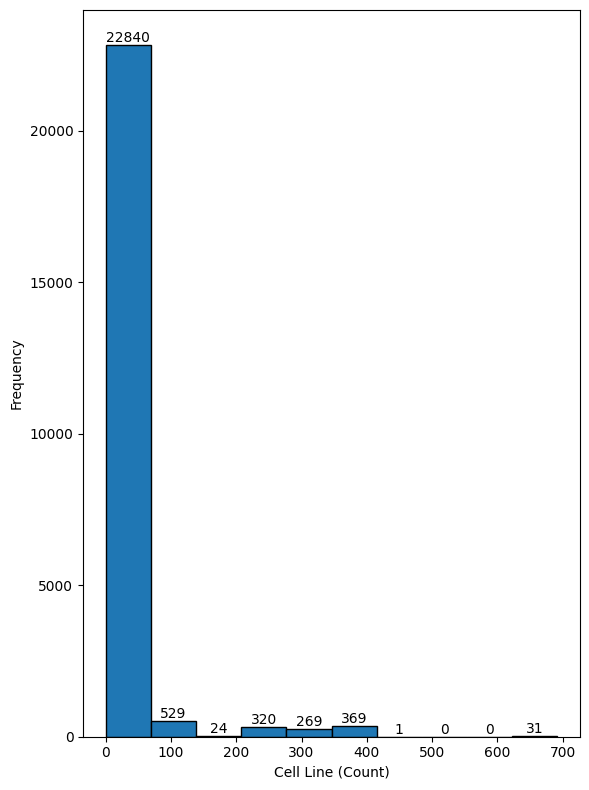

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 8))

counts, bins, patches = plt.hist(column_count_df['Count'], bins=10, edgecolor='black')


for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    x = (bin_left + bin_right) / 2  
    y = count  
    plt.text(x, y, f'{int(count)}', ha='center', va='bottom')  


plt.xlabel('Cell Line (Count)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [49]:
filt_gene_count_df = column_count_df.head(10)
filt_gene_count_df

,Gene,Count
24382,DAZ3 (57054),692
24379,PRORY (100533178),690
24371,TTTY14 (83869),690
24372,BCORP1 (286554),690
24373,TXLNGY (246126),690
24380,TTTY13 (83868),690
24377,EIF1AY (9086),689
24376,TTTY10 (246119),689
24375,AC010889.2 (105377224),689
24374,KDM5D (8284),689


In [59]:
# 결과 저장 리스트
significant_pairs = []

# Correlation
for idx1 in copy_number.index:
    for idx2 in gene_effect.index:
        # Remove Nan Value
        row1 = copy_number.loc[idx1].dropna()
        row2 = gene_effect.loc[idx2].dropna()

        # Double Checking for common index
        common_index = row1.index.intersection(row2.index)
        row1 = row1[common_index]
        row2 = row2[common_index]

        
        if len(row1) > 1:
            correlation, p_value = spearmanr(row1, row2)

            # filtering
            if correlation >= 0.3 and p_value < 0.05:
                significant_pairs.append((idx1, idx2, correlation, p_value))

# For Data Frame
result_df = pd.DataFrame(significant_pairs, columns=["CN", "GeneEffect", "Correlation", "P-value"])

KeyboardInterrupt: 

In [60]:
from multiprocessing import Pool
import pandas as pd

# calculation function
def calculate_correlation(pair):
    idx1, idx2 = pair
    row1 = copy_number.loc[idx1].dropna()
    row2 = gene_effect.loc[idx2].dropna()
    common_index = row1.index.intersection(row2.index)
    row1 = row1[common_index]
    row2 = row2[common_index]

    if len(row1) > 1:
        correlation, p_value = spearmanr(row1, row2)
        if correlation >= 0.3 and p_value < 0.05:
            return idx1, idx2, correlation, p_value
    return None

# All combination check
pairs = [(idx1, idx2) for idx1 in copy_number.index for idx2 in gene_effect.index]

# MultiProcessing
with Pool(processes=4) as pool:  # Checking for CPU core
    results = pool.map(calculate_correlation, pairs)

# Results
significant_pairs = [res for res in results if res is not None]
result_df = pd.DataFrame(significant_pairs, columns=["CN", "GeneEffect", "Correlation", "P-value"])
